## Inicjalizacja środowiska programistycznego

In [ ]:
#Color printing
from termcolor import colored

#General data operations library
import math, string, glob
from datetime import datetime
import numpy as np
import functools

#The tensorflow library
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

import tensorflow  as tf
import tensorflow_datasets as tfds
import tensorflow_text as tf_text

import logging
tf.get_logger().setLevel(logging.ERROR)

#Plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt

#Increase plots font size
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (10, 7),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params) 

import os
os.chdir("/scratch_hdd/akalinow/Zajecia/2023-2024/Lato/Uczenie_maszynowe_2/UczenieMaszynoweII/PL/")

#append path with python modules
import importlib
import sys
sys.path.append("../modules")

#Private functions
import plotting_functions as plf
importlib.reload(plf);

#Hide GPU
#tf.config.set_visible_devices([], 'GPU')

<br/><br/>
<br/><br/>

<h1 align="center">
 Uczenie maszynowe II
</h1>

<br/><br/>
<br/><br/>
<br/><br/>
<br/><br/>

<h1 align="right">
Artur Kalinowski <br>
Uniwersytet Warszawski <br>
Wydział Fizyki <br>    
</h1>

## Komórki rekurencyjne - jednostki w których wartość wyjściowa jest podawana z powrotem na wejście. 
Wartości wyjściowe i wejściowe są obliczane w krokach "czasowych".
Wyjście z poprzedniego kroku, `i-1`, jest podawane na wejście w aktualnym kroku, `i`:

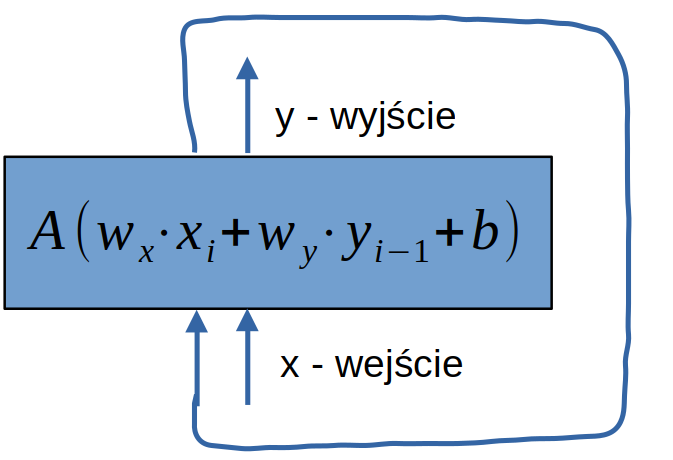

Stan neuronu w kroku `i` jest nazywany zwykle stanem ukrytym, `ang. hidden` i nie musi być on tożsamy z wartością wyjściową neuronu.
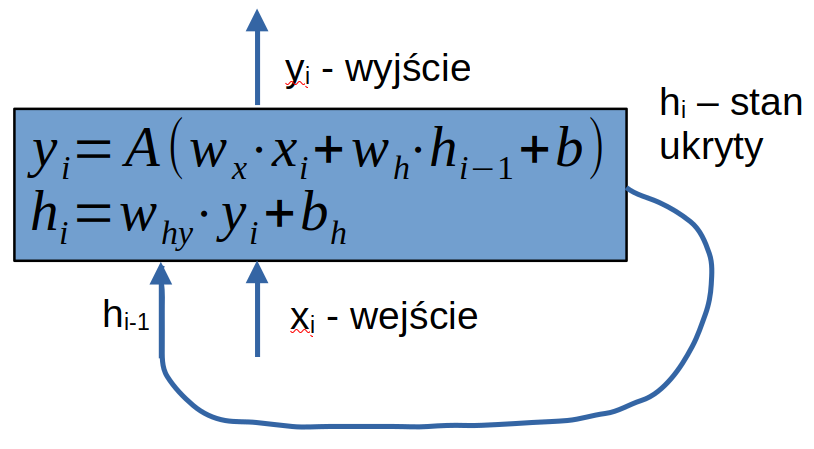

Standardowo komórki RNN przetwarzają sekwencje: 

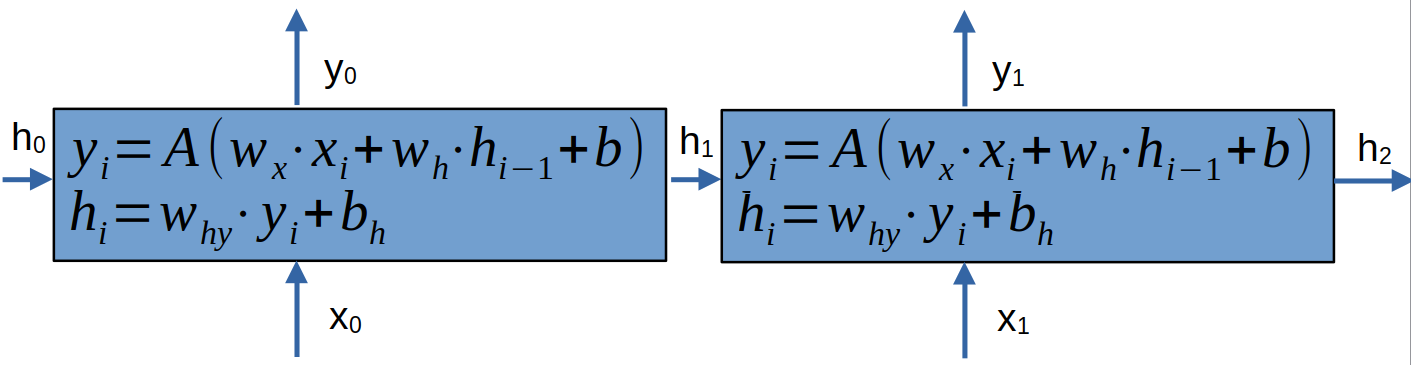

Warstwa zawierająca najprostszy wariant, **bez dodatkowego mieszania składowych stanu ukrytego,**  komórki rekurencyjnej, ang. `Recurrent Neural Network cell, RNN cell` 
jest zaimplementowana w interfejsie użytkownika Keras jako

```Python
tf.keras.layers.SimpleRNN(
    units,                              # liczba neuronów
    activation='tanh',                  # funkcja aktywacji. W RNN zwykle używa się tanh(x)
    use_bias=True,                      # czy wartwa ma używać wyrazów wolnegych?
    recurrent_initializer='orthogonal', # inicjalizacja wag mieszających składowe stanu ukrytego
    recurrent_regularizer=None,         # regularyzacja wag mieszających składowe stanu ukrytego
    dropout=0.0,                        # ułamek losowo zerowanych składowych danych wejściowych
    recurrent_dropout=0.0,              # ułamek losowo zerowanych skłądowych stanu ukrytego
    return_sequences=False,             # czy warstwa ma zwracać sekwencję wartości w kolejnych krokach?
    return_state=False,                 # czy warstwa ma zwracać stan ukryty?
    go_backwards=False,                 # czy warstwa ma przetwarzać sekwencję w odwrotnej kolejności?
)
```

In [ ]:
batchSize = 1
nTimeSteps = 3
inputDimension = 2
outputDimension = 2

inputs = np.random.random((batchSize, nTimeSteps, inputDimension))
simple_rnn = tf.keras.layers.SimpleRNN(outputDimension)
output = simple_rnn(inputs)  
print(colored("RNN cell output:","blue"), output)

simple_rnn = tf.keras.layers.SimpleRNN(inputDimension,
                                       return_sequences=True, 
                                       return_state=True)
output = simple_rnn(inputs)  
print(colored("RNN cell output:","blue"), output)

Badanie działania komórki RNN.

**Proszę:**

* przygotować dane wejściowe dla warstwy RNN: 
    * jedna paczka
    * sto kroków czasowych
    * kolejne liczby całkowite w każdym kroku: `(0)`, `(1)` itd.

 * wypisać na ekran dane dla pierwszych pięciu kroków i ich kształt. 
 * sprawdzić czy kształt jest poprawny: `(batchSize, nSteps, inputDim)`   

In [ ]:
#BEGIN_SOLUTION
batchSize = 1
nTimeSteps = 100
outputDimension = 1
inputs = np.arange(0, nTimeSteps, 1).reshape(batchSize, nTimeSteps, outputDimension)

print(colored("Inputs:","blue"), inputs[:,0:5,:])
print(colored("Inputs shape:","blue"), inputs.shape)
#END_SOLUTION
pass



**Proszę:**

* użyć własnej funkcji inicjalizującej wagi tak by komórka RNN zwracała sumę elementów w sekwencji

**Wskazówki:**
* uwaga na funkcję aktywacji


In [ ]:
try: 
    class customInitializer(tf.keras.Initializer):
        def __init__(self, kernel):
            self.kernel = kernel

        def __call__(self, shape, dtype=None, **kwargs):
            x = tf.reshape(self.kernel, shape)
            x= tf.cast(x, dtype)
            return x  
except AttributeError:
    print(colored("tf.keras.Initializer not available","red"))
    print(colored("TF version:","blue"),tf.__version__)
    pass

In [ ]:
#BEGIN_SOLUTION
inputDimension = 1
kernel_matrix = np.diag([1])
recurrent_kernel_matrix = np.diag([1])

simple_rnn = tf.keras.layers.SimpleRNN(inputDimension,
                                       activation='linear',
                                       kernel_initializer=customInitializer(kernel_matrix),
                                       recurrent_initializer=customInitializer(recurrent_kernel_matrix),
                                       #return_sequences=True, 
                                       #return_state=True
                                       )

output = simple_rnn(inputs, initial_state= tf.constant([[0]], dtype=tf.float64))
print(colored("input:","blue"), inputs[:,0:5,:])
print(colored("RNN cell output:","blue"), output[:,0:5])
print(colored("Sequence sum:","blue"), np.sum(inputs, axis=1))
#END_SOLUTION
pass


Komórka RNN ma pewną wadę: wyjście jest średnią ważoną wejścia i stanu z poprzedniego kroku. To oznacza, że dane z odległym kroków w przeszłości nie mają wpływu na stan komórki w danym kroku - komórka ma jedynie pamięć krótkotrwałą. Rozwiązaniem tego problemu jest wyposażenie komórki w dodatkowy stan ukryty, który może przechowywać dane w długim kresie czasu - pamięć długotrwałą. Komórka ma więc dwa rodzaje pamięci - krótko- i długo-trwałą, ang. `Long Short-Term Memory, LSTM`.




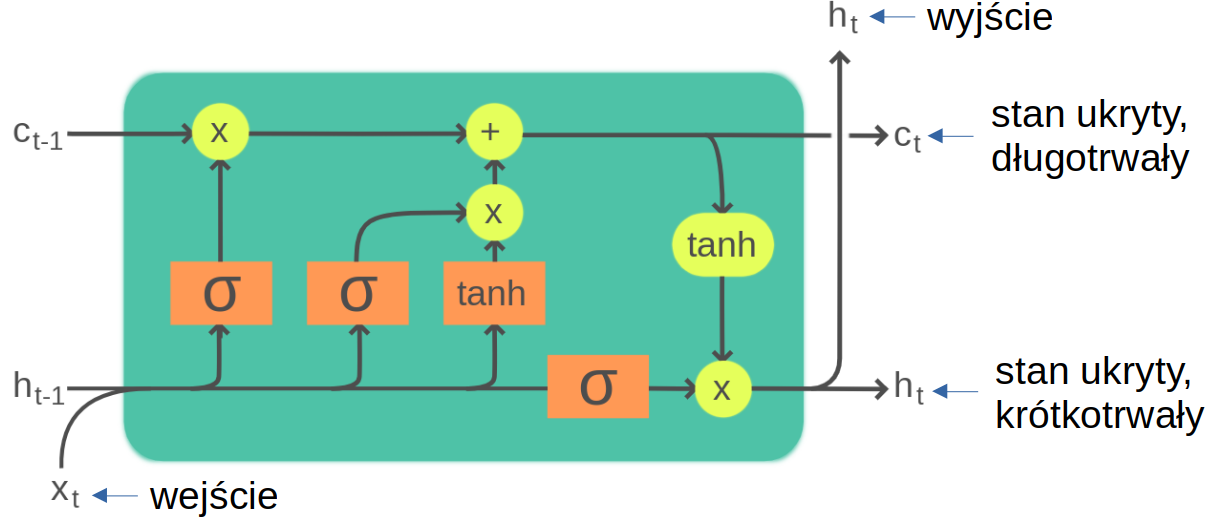

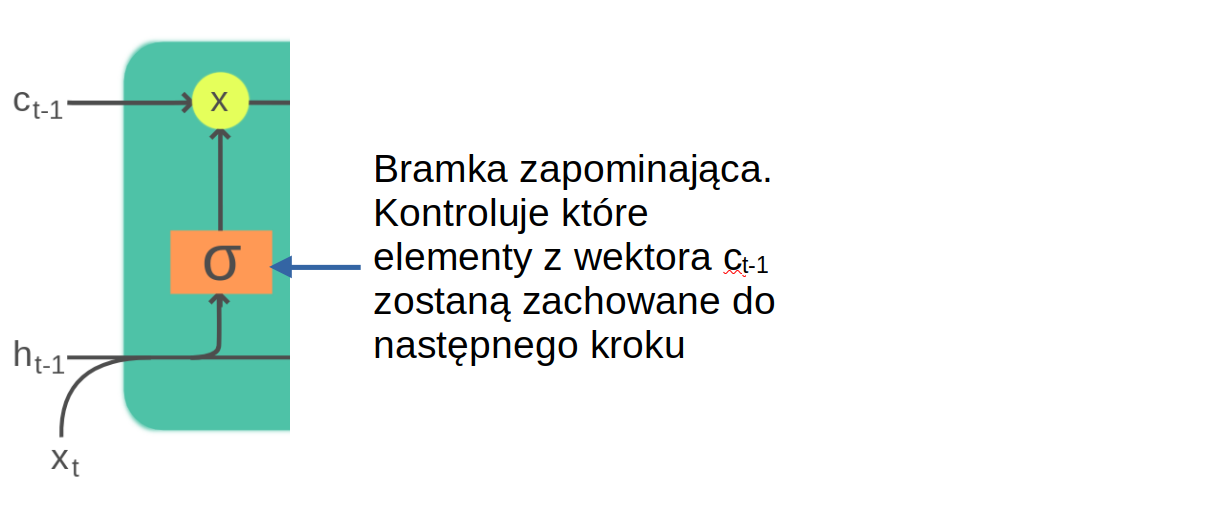

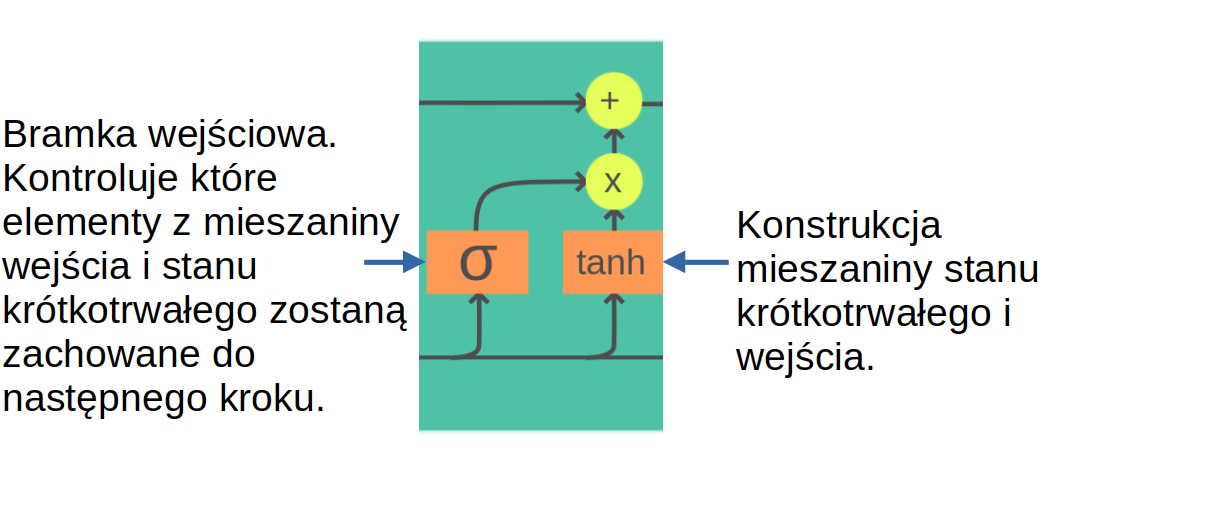

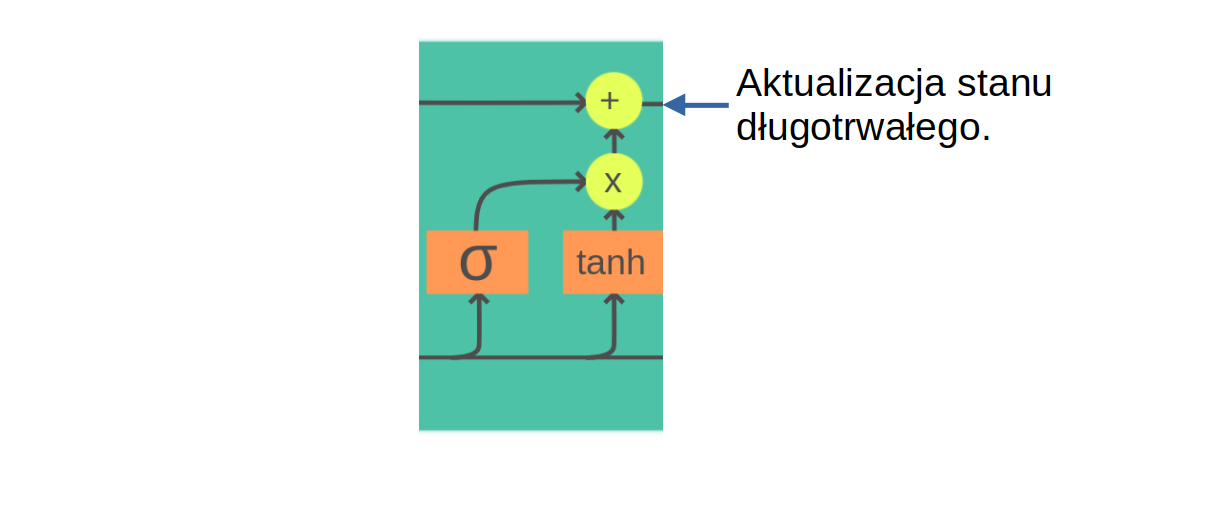

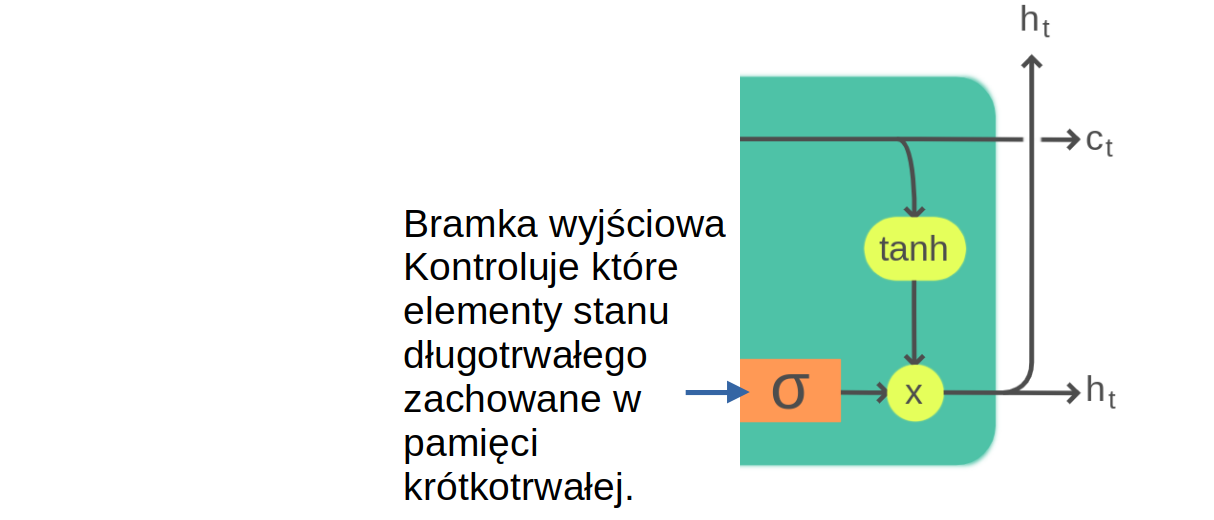

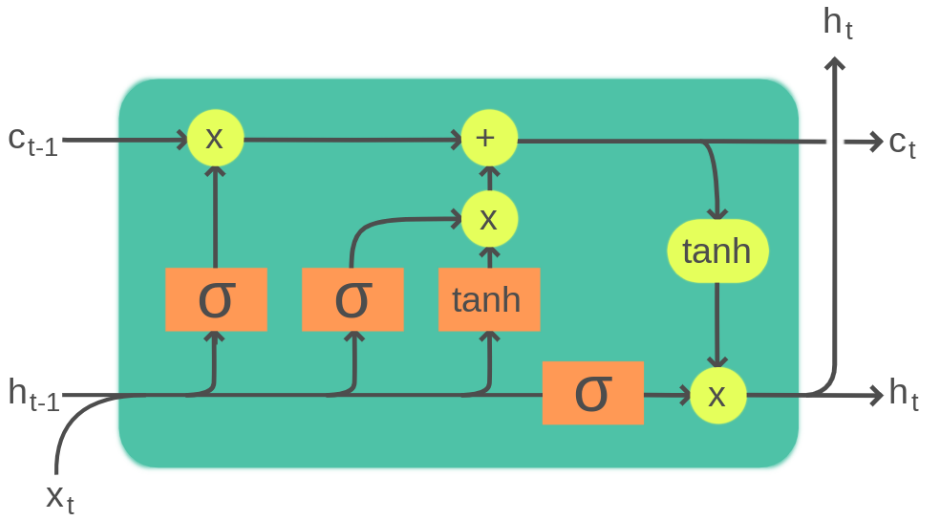

Implementacja komórki LSTM w Keras:
```Python
tf.keras.layers.LSTMCell(
    units,
    activation='tanh',
    recurrent_activation='sigmoid',
    use_bias=True,
    kernel_initializer='glorot_uniform',
    recurrent_initializer='orthogonal',
    bias_initializer='zeros',
    unit_forget_bias=True,
    kernel_regularizer=None,
    recurrent_regularizer=None,
    bias_regularizer=None,
    kernel_constraint=None,
    recurrent_constraint=None,
    bias_constraint=None,
    dropout=0.0,
    recurrent_dropout=0.0,
    seed=None,
    **kwargs
)
```

**Proszę:**

* napisać funkcję `generateFibonacci(n)` która generuje pierwszych `n` elementów ciągu Fibonacciego:
$$
\huge{
F_{n} = F_{n-1} + F_{n-2}, F_{0} = 0, F_{1} = 1
}
$$

* stworzyć macierz `fib_sequence` zawierającą pierwsze `30` elementów ciągu Fibonacciego
* podzielić listę na fragmenty o długości `window_size=3` używając ruchomego okna z krokiem `1`.
* wypisać na ekran oryginalną i podzieloną listę

In [235]:
#BEGIN_SOLUTION
fib = [0, 1]

def generateFibonacci(n=30):
    while len(fib) < n:
        fib.append(fib[-1] + fib[-2])
        yield fib[-1]

fib_sequence = np.array([x for x in generateFibonacci()])

window_size = 6
slidingWindowWithWidth = functools.partial(tf_text.sliding_window, width=window_size)

print(colored("Fibonacci sequence:","blue"), fib)
print(colored("Fibonacci sequence split into windows:","blue"), slidingWindowWithWidth(fib))
#END_SOLUTION
pass


Fibonacci sequence: [0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1597, 2584, 4181, 6765, 10946, 17711, 28657, 46368, 75025, 121393, 196418, 317811, 514229]
Fibonacci sequence split into windows: tf.Tensor(
[[     0      1      1      2      3      5]
 [     1      1      2      3      5      8]
 [     1      2      3      5      8     13]
 [     2      3      5      8     13     21]
 [     3      5      8     13     21     34]
 [     5      8     13     21     34     55]
 [     8     13     21     34     55     89]
 [    13     21     34     55     89    144]
 [    21     34     55     89    144    233]
 [    34     55     89    144    233    377]
 [    55     89    144    233    377    610]
 [    89    144    233    377    610    987]
 [   144    233    377    610    987   1597]
 [   233    377    610    987   1597   2584]
 [   377    610    987   1597   2584   4181]
 [   610    987   1597   2584   4181   6765]
 [   987   1597   2584   4181   6765  10946]
 [  159

**Proszę:**

* stworzyć obiekt `tf.data.Dataset` którego elementami są trójki kolejnych elementów ciągu Fibonacciego
* przetworzyć wiersze w danych do postaci `(features, label)`  gdzie  `label` to ostatni element grupy, a `features` to pozostałe
* zadbać by cechy miały kształt oczekiwany przez warstwy rekurencyjne 
* wypisać na ekran pierwsze cztery wiersze danych

In [234]:
scale = max(fib)
dataset = tf.data.Dataset.from_tensor_slices(slidingWindowWithWidth(fib))
dataset = dataset.map(lambda x: tf.reshape(x, (1, window_size, 1))).map(lambda y: (y[:,:-1,:], y[:,-1,:])).cache()  

for item in dataset.take(4):
    print(colored("Features:","blue"), item[0].numpy()[0,:,0], end=" ")
    print(colored("Labels:","blue"), item[1].numpy()[0]) 


Features: [0 1 1 2 3] Labels: [5]
Features: [1 1 2 3 5] Labels: [8]
Features: [1 2 3 5 8] Labels: [13]
Features: [ 2  3  5  8 13] Labels: [21]


2024-05-09 15:14:06.371347: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-05-09 15:14:06.371719: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


**Proszę:**

* zbudować i wytrenować model z komórką RSTM który przewidzi następny element ciągu Fibonacciego na podstawie dwu poprzednich elementów


Model: "fib_generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_46 (LSTM)                  │ (None, 1)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12 (48.00 B)

 Trainable params: 12 (48.00 B)

 Non-trainable params: 0 (0.00 B)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - loss: 2643723.7500


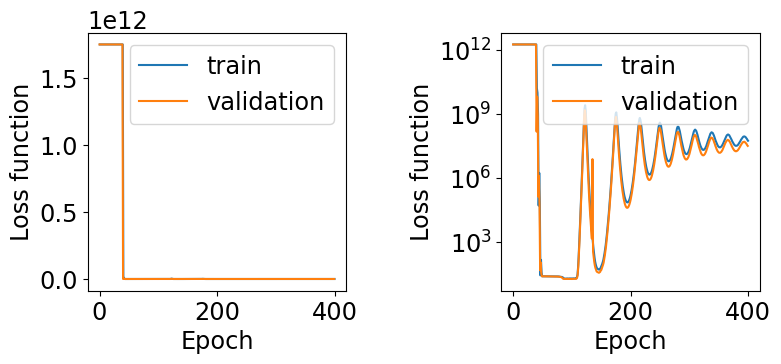

In [232]:
model = tf.keras.Sequential(layers = [tf.keras.layers.InputLayer(shape=(None, 1)),
    tf.keras.layers.LSTM(1, activation='linear',  
                            bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1))],
    name="fib_generator")  

model.build()
model.summary()

initial_learning_rate = 1E-3
nStepsPerEpoch = slidingWindowWithWidth(fib).shape[0]
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,
                decay_steps=nStepsPerEpoch*50,
                decay_rate=0.95,
                staircase=False)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
              loss='mse', metrics=[])

history = model.fit(dataset, 
                    validation_data=dataset,
                    epochs=400, verbose=0)
model.evaluate(dataset)
plf.plotTrainHistory(history)  

**Proszę:**

* wypisać na ekran etykiety i efekt działania modelu
* narysować panel z dwoma rysunkami:
   * X=model,  Y=etykieta
   * X=numer elementu, Y=model/etykieta

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step
Label, prediction: 5 6
Label, prediction: 8 8
Label, prediction: 13 12
Label, prediction: 21 20
Label, prediction: 34 33
Label, prediction: 55 55
Label, prediction: 89 90
Label, prediction: 144 145
Label, prediction: 233 233
Label, prediction: 377 376
Label, prediction: 610 608
Label, prediction: 987 984
Label, prediction: 1597 1593
Label, prediction: 2584 2578
Label, prediction: 4181 4169
Label, prediction: 6765 6743
Label, prediction: 10946 10906
Label, prediction: 17711 17643
Label, prediction: 28657 28543
Label, prediction: 46368 46180
Label, prediction: 75025 74716
Label, prediction: 121393 120890
Label, prediction: 196418 195600
Label, prediction: 317811 316483
Label, prediction: 514229 512076


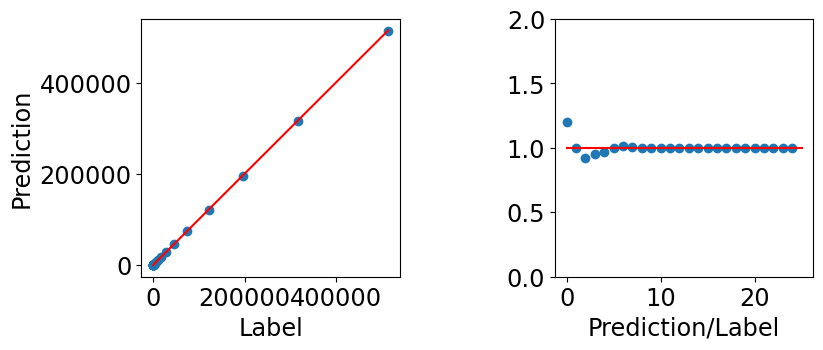

In [236]:
predictions = model.predict(dataset)[:,0].astype(int)
labels = fib_sequence[window_size-3:]

for label, prediction in zip(labels, predictions):
    print(colored("Label, prediction:","blue"), label, prediction)

fig, axes = plt.subplots(1, 2, figsize=(7,3))

axes[0].plot(labels, predictions, 'o')
axes[0].plot([0,max(labels)], [0,max(labels)], 'r')
axes[0].set_xlabel("Label")
axes[0].set_ylabel("Prediction")

axes[1].plot(predictions/labels, 'o')
axes[1].plot([0,len(labels)], [1,1], 'r')
axes[1].set_xlabel("Prediction/Label")
axes[1].set_ylim([0,2])
plt.subplots_adjust(bottom=0.02, left=0.02, right=0.98, wspace=0.6)